# detectron2 for まちカドまぞく ～評価編～

<img src="https://user-images.githubusercontent.com/33882378/79055211-32534000-7c86-11ea-809e-3c77856e122b.jpg">

detectron2 で独自データセット学習したモデルで評価する方法

参考にしたホームページ: https://demura.net/deeplearning/16807.html

In [1]:
import os
import numpy as np
import json
import cv2
import random
import matplotlib.pyplot as plt

---
## 独自のデータセットを読み込んで、データセットを用意する

### VoTT Export からの読み込み

* vott 関係は py ファイルにしておいた

In [2]:
# VoTT のエクスポートファイルや、画像が格納されているディレクトリ
BASE_DIRECTORY = './vott-json-export/'
# VoTT のエクスポートファイル名
EXPORT_FILENAME = 'Machikado-export.json'
# 訓練データに使用する割合
TRAIN_RATIO = 0.8
# 乱数シード
RANDOM_STATE = 0  # 訓練と同じにしておかないとズレちゃうよ！

In [3]:
from detectron2.data import DatasetCatalog, MetadataCatalog

from Machikado_vott import get_cat_names, get_machikado_dicts

# vott の読み込み関係は py ファイルにした
CAT_NAME2ID, CAT_ID2NAME = get_cat_names(os.path.join(BASE_DIRECTORY, EXPORT_FILENAME))
dataset_dicts = get_machikado_dicts(os.path.join(BASE_DIRECTORY, EXPORT_FILENAME), BASE_DIRECTORY, CAT_NAME2ID)

# 日本語表示を試す(CAT_ID2NAME と順番を一致させること！)
CAT_NAME_JP = cat_name_jp = ['シャミ子', 'ごせん像', 'リリス', 'もも', 'みかん', 'その他']
    
# 訓練用、テスト用に分ける
random.seed(RANDOM_STATE)
random.shuffle(dataset_dicts)

split_idx = int(len(dataset_dicts) * TRAIN_RATIO) + 1

# 登録
DatasetCatalog.clear()
DatasetCatalog.register('train', lambda : dataset_dicts[:split_idx])
DatasetCatalog.register('test', lambda : dataset_dicts[split_idx:])

# 日本語名はこっち
MetadataCatalog.get('train').set(thing_classes=CAT_NAME_JP)
MetadataCatalog.get('test').set(thing_classes=CAT_NAME_JP)

# VoTT のカテゴリ名はこっち
# MetadataCatalog.get('train').set(thing_classes=list(CAT_NAME2ID.keys()))
# MetadataCatalog.get('test').set(thing_classes=list(CAT_NAME2ID.keys()))

警告: name: 59.jpg - 画像サイズの不整合 image_size:(268, 201), ./vott-json-export/Machikado-export.json: (600, 600)


Metadata(name='test', thing_classes=['シャミ子', 'ごせん像', 'リリス', 'もも', 'みかん', 'その他'])

---
## ここから推論

* utils/visualizer.py の 792行目あたり（フォントを指定しているところ）をコメントアウトすると日本語が使える。（ちなみに matplotlib で日本語が表示できる環境になっていないとダメ）
* バッチで推論したければ、DefaultPredictor を参考にオリジナル作ればいけそう。
* ```cfg.MODEL.WEIGHTS = ``` の部分は使用したい重みファイルに変える。デフォルトなら ```cfg.MODEL.WEIGHTS = cfg.OUTPUT_DIR, 'model_final.pth'``` です。

In [4]:
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.OUTPUT_DIR = './output'

# cfg.merge_from_file("../configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml") # ここの位置は ipynb ファイルの層泰一なので注意
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final.pth')

cfg.merge_from_file('../configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml')
cfg.SOLVER.IMS_PER_BATCH = 1 # GTX2070 ではこれが限界
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final.pth')

#cfg.DATASETS.TRAIN = ('train',)  # これは必須じゃない (DatasetCatalog.get の時にこれ使うんだと思う)
#cfg.DATASETS.TEST = ('test', ) 
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(CAT_ID2NAME)  # machikado は6
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final.pth')

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model

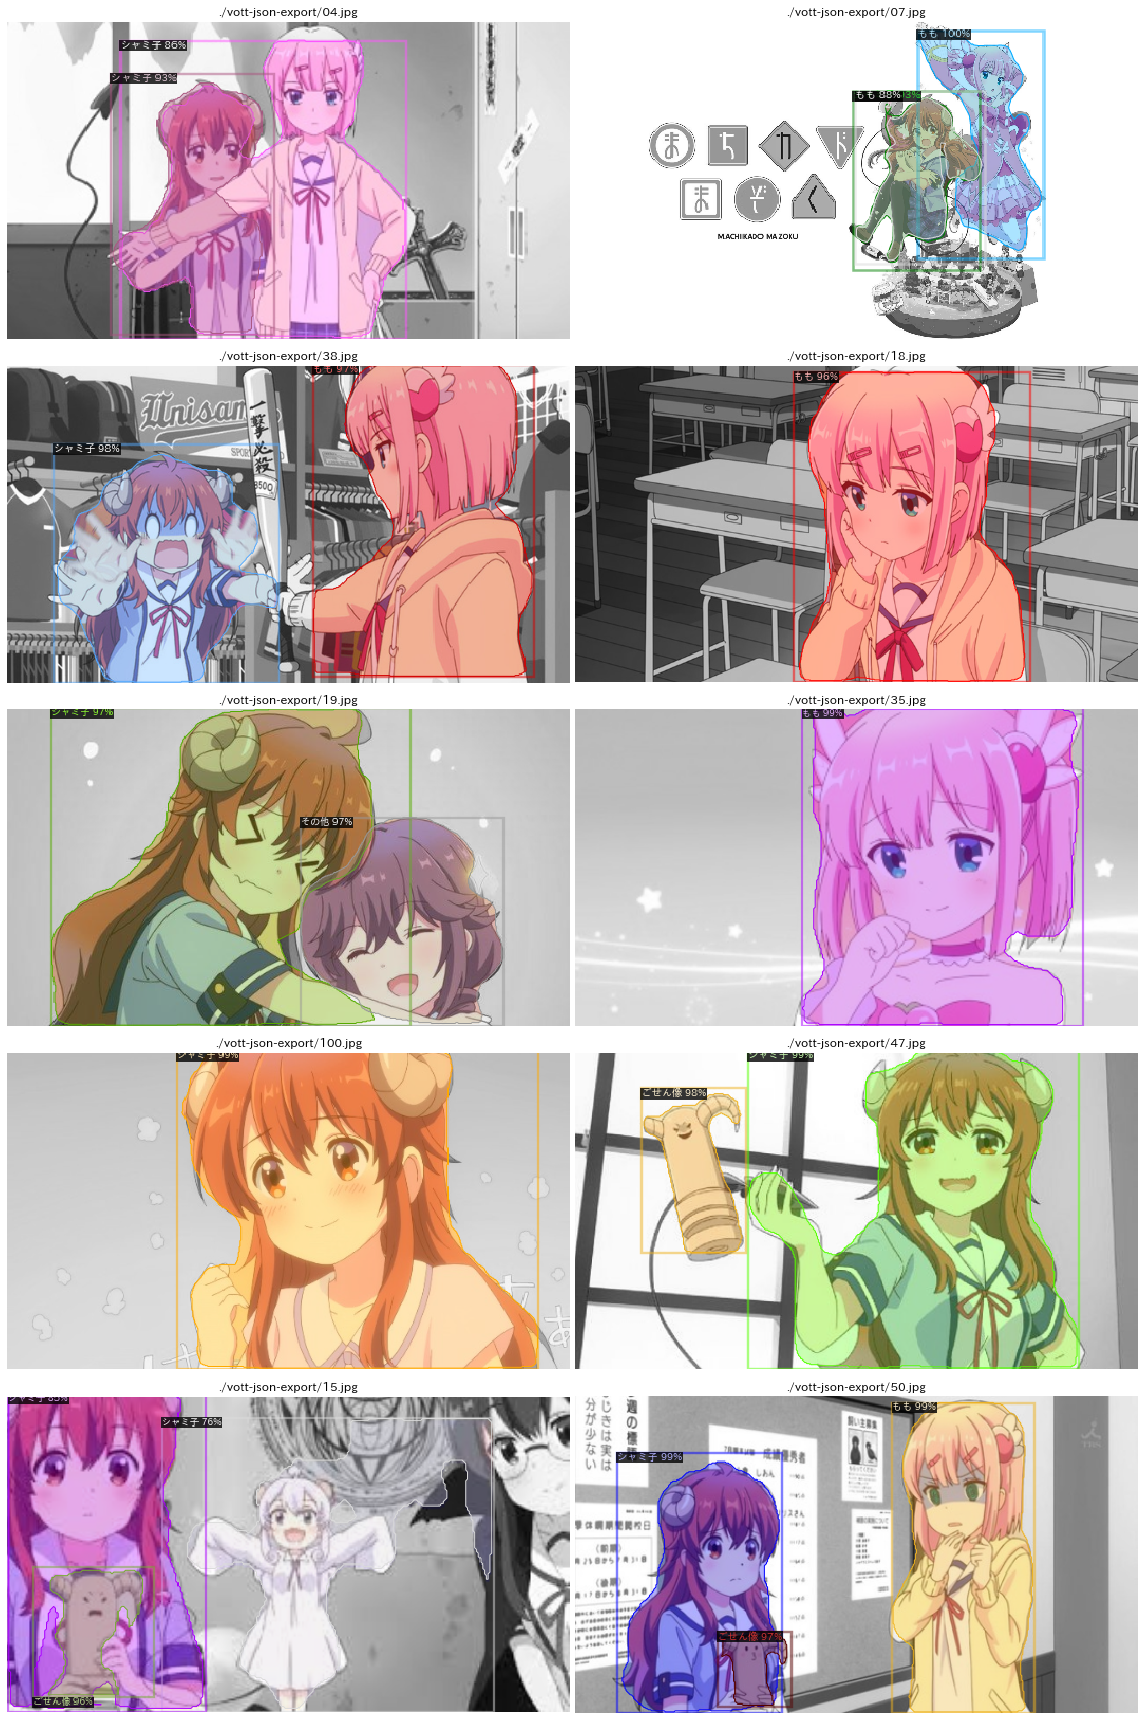

In [5]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# random.seed(RANDOM_STATE)

predictor = DefaultPredictor(cfg)

# False で train データを使用して推論
SEL_TEST = True

plt.figure(figsize=(16, 24))  # サイズは調整してください

for i, asset in enumerate(random.sample(DatasetCatalog.get('test' if SEL_TEST else 'train'), 10)):
    w, h = asset['width'], asset['height']
    img = cv2.imread(asset["file_name"])
    outputs = predictor(img)
    
    v = Visualizer(img[:, :, ::-1],
                   metadata=MetadataCatalog.get('test' if SEL_TEST else 'train'), 
                   scale=max([300 / w, 300 / h]),  # 画像サイズに合わせてスケールを変更させた（見やすくなる）
                   instance_mode=ColorMode.IMAGE_BW)   # remove the colors of unsegmented pixels
    
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    ax = plt.subplot(5, 2, i + 1)
    ax.imshow(v.get_image())
    ax.set_title(asset['file_name'])
    ax.axis('off')

plt.tight_layout()
plt.show()